# Build Your Own Hypothesis
Author: Rich Pihlstrom

## Overview
The idea behind this code is to allow you to test your own hypotheses. You will be able to choose what variables you want to compare, as well as other parameters like time shift or time window. As you draw inference from different hypotheses, you can add your tests and conclusions to [this spreadsheet](https://docs.google.com/spreadsheets/d/15yBqDRTcaXI7R88JRcvbHJnZWMTMC6LUwJX3k7OD4Jc/edit#gid=1343855687).

## Datasets
The data is split into two files, one for IDP numbers ARRIVING at the location and another for IDP numbers LEAVING from the location.

In [683]:
inMigration_file = "Helge_code/Sudan_states_inmigration_2023-10-21.csv"
outMigration_file = "Helge_code/Sudan_states_outmigration_2023-10-21.csv"

The time granularity mirrors the intervals of reports provided by IOM; they are roughly weekly, with some exceptions. In order to get the daily tweet data to this level, the data has been aggregated using three methods: sum, maximum, and mean.

For both sentiment and emotion labeling, there are 3 models—lexicon, machine learning, and large language model:
* Sentiment
    * comboLex: lexicon method that captures positive, negative, and neutral sentiment scores
    * SVM: machine learning method that captures just negative=0/positive=1 binary labels
    * multiBERT: large language model that captures positive and negative sentiment scores
* Emotion
    * Lex: lexicon method for binary emotion multi-labels
    * NaiveBayes: machine learning method for binary emotion multi-labels
    * GloVe: large language method for binary emotion multi-labels

The emotions captured by the emotion models are anger, fear, sadness, disgust, joy, and anger-disgust.

In [684]:
agg_methods = ["sum","mean","max"]
senti_models = ["comboLex","SVM","multiBERT"]
emo_models = ["Lex","NaiveBayes","GloVe"]
emotions = ["anger","fear","sadness","disgust","joy","anger-disgust"]

## Initializations

### Libs

In [685]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

### Read in files

In [686]:
with open(inMigration_file,"r") as f1, open(outMigration_file,"r") as f2:
    in_m = pd.read_csv(f1).rename(columns={"to":"location","val":"IDP"})
    out_m = pd.read_csv(f2).rename(columns={"from":"location","val":"IDP"})
in_m["date_later"] = pd.to_datetime(in_m["date_later"])
out_m["date_later"] = pd.to_datetime(out_m["date_later"])
in_m["flow"] = "IN"
out_m["flow"] = "OUT"

df_dict = {
    "in":in_m,
    "out":out_m
}

locations = {i:loc for i, loc in enumerate(list(in_m["location"].unique()))}

### IN Migration Dataframe

In [687]:
in_m

,location,date_later,IDP,sentiment_pos_comboLex_mean,sentiment_neg_comboLex_mean,sentiment_neu_comboLex_mean,sentiment_SVM_mean,sentiment_pos_multiBERT_mean,sentiment_neg_multiBERT_mean,anger_NaiveBayes_mean,...,disgust_Lex_max,joy_Lex_max,anger-disgust_Lex_max,anger_GloVe_max,fear_GloVe_max,sadness_GloVe_max,disgust_GloVe_max,joy_GloVe_max,anger-disgust_GloVe_max,flow
0,Aj Jazirah,2023-04-27,8795.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IN
1,Aj Jazirah,2023-05-05,41085.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IN
2,Aj Jazirah,2023-05-12,10245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IN
3,Aj Jazirah,2023-05-21,4109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IN
4,Aj Jazirah,2023-05-29,5050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,White Nile,2023-07-12,6768.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IN
284,White Nile,2023-07-23,4157.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IN
285,White Nile,2023-07-27,264.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IN
286,White Nile,2023-08-04,4358.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IN


### OUT Migration Dataframe

In [688]:
out_m

,location,date_later,IDP,sentiment_pos_comboLex_mean,sentiment_neg_comboLex_mean,sentiment_neu_comboLex_mean,sentiment_SVM_mean,sentiment_pos_multiBERT_mean,sentiment_neg_multiBERT_mean,anger_NaiveBayes_mean,...,disgust_Lex_max,joy_Lex_max,anger-disgust_Lex_max,anger_GloVe_max,fear_GloVe_max,sadness_GloVe_max,disgust_GloVe_max,joy_GloVe_max,anger-disgust_GloVe_max,flow
0,Aj Jazirah,2023-04-27,950.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OUT
1,Aj Jazirah,2023-05-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OUT
2,Aj Jazirah,2023-05-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OUT
3,Aj Jazirah,2023-05-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OUT
4,Aj Jazirah,2023-05-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OUT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,White Nile,2023-07-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OUT
284,White Nile,2023-07-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OUT
285,White Nile,2023-07-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OUT
286,White Nile,2023-08-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OUT


#### We are interested in performing lead-lag analyses. This function takes as input the dataframe for which we want to shift time, and the time-delta td by which we want to shift. Note, because the migration data is at a roughly-weekly granularity, we must shift by a matching time unit (rather than, say, days). The list output below contains all values on the scale on which we shift.

In [689]:
def time_shift(df, td, date_col = "date_later", val_col = "IDP", loc_col = "location"):
    dates = list(df[date_col].unique())
    def shift(date):
        if dates.index(date)+td < 0 or dates.index(date)+td >= len(dates):
            return "08/11/2024"
        else:
            return dates[dates.index(date)+td]

    left = df[[date_col,val_col,loc_col]].copy()
    right = df[[elem for elem in df.columns if elem!=val_col]].copy()
    right[date_col] = pd.to_datetime(right[date_col].apply(shift))
    return pd.merge(left, right, on = [date_col,loc_col], how = "inner")
dates = sorted([pd.to_datetime(date).strftime('%m/%d/%Y') for date in in_m['date_later'].unique()])
dates

['04/27/2023',
 '05/05/2023',
 '05/12/2023',
 '05/21/2023',
 '05/29/2023',
 '06/04/2023',
 '06/08/2023',
 '06/14/2023',
 '06/21/2023',
 '06/28/2023',
 '07/05/2023',
 '07/12/2023',
 '07/23/2023',
 '07/27/2023',
 '08/04/2023',
 '08/10/2023']

#### In the data, particularly the OUT-flow data, there are a number of instances where we impute zeroes for locations because IOM did not provide information about that location-date. This has the potential to skew data. As such, this function will simply un-impute those zeroes, removing any row where the "IDP" and the tweet labels are entirely zero.

In [690]:
def rm_0_rows(df):
    return df[~(df[df.columns[2:]] == 0).all(axis=1)]

#### We will focus a lot on the correlation between variables. This code takes two sets of columns that we want to compare and returns a correlation matrix for each pair of values—one from each column.

In [691]:
def corrMat(covars, responses, df):
    corrMat = pd.DataFrame(columns=covars, index=responses)
    for c2 in covars:
        for c1 in responses:
            corrMat.at[c1, c2] = df[c2].corr(df[c1])
    return corrMat

## DIY
### Choosing your parameters

#### 1. Do you want to focus on in-migration, out-migration, or both?
*Choose one or both of "in", "out"*

In [692]:
flow_choice = ["out"] # EDIT ME

#### 2. Would you like to leave imputed zero-rows in the data?
*"Y" to keep rows or "N" to remove*

In [693]:
keep_zero_rows = "N" # EDIT ME

#### 3. What variables would you like to consider?
*Choose one or more from "emotion","sentiment","migration"*

In [694]:
vars = ["emotion","migration"] # EDIT ME

#### 4. What sentiment and emotion models would you like to consider?
*For sentiment, choose one or more from "comboLex","SVM","multiBERT"*

*For emotion, choose one or more from "Lex","NaiveBayes","GloVe"*

You can leave blank any option that you did not include in your variable selection

In [695]:
senti_model = ["multiBERT"] # EDIT ME
emo_model = ["GloVe"] # EDIT ME

#### 5. What aggregation methods would you like to consider?
*Choose one or more from "sum","mean","max"*

In [696]:
aggs = ["mean"] # EDIT ME

#### 6. Of the location choices listed below, select which one(s) you would like to consider. Alternatively, just enter "all" if you do not want to subset by location.
* You can either enter the index or the name*

In [697]:
locations

{0: 'Aj Jazirah',
 1: 'Blue Nile',
 2: 'Central Darfur',
 3: 'East Darfur',
 4: 'Gedaref',
 5: 'Kassala',
 6: 'Khartoum',
 7: 'North Darfur',
 8: 'North Kordofan',
 9: 'Northern',
 10: 'Red Sea',
 11: 'River Nile',
 12: 'Sennar',
 13: 'South Darfur',
 14: 'South Kordofan',
 15: 'West Darfur',
 16: 'West Kordofan',
 17: 'White Nile'}

In [698]:
locs = ["all"] # EDIT ME

#### 7. Would you like to time shift the variable data?
*Choose an integer value for the units by which you will shift the variable data. Recall that the shift value represents the weekly-ish time units of the migration data, NOT days or weeks. Value can be positive or negative for shift forward/backward*

*Leave as 0 if you do not want to shift*

In [699]:
td = -2 # EDIT ME

### Your new dataframe

In [700]:
constant_cols = ["location","flow","date_later"] 

df = pd.concat([df_dict[flow] for flow in flow_choice])

if keep_zero_rows == "N":
    df = rm_0_rows(df)

df = time_shift(df, td)

cols = ([c for c in df.columns if any(emo in c for emo in emotions)] if "emotion" in vars else []) +\
    ([c for c in df.columns if "sentiment" in c] if "sentiment" in vars else []) + (["IDP"] if "migration" in vars else [])

cols = [c for c in cols if any(model in c for model in senti_model + emo_model) or c=="IDP"]

cols = [c for c in cols if any(agg in c for agg in aggs) or c=="IDP"]

if "all" not in locs:
    for i, choice in enumerate(locs):
        if type(choice) == int:
            locs[i] = locations[choice]
    df = df[df["location"].isin(locs)]

df = df[constant_cols + cols]
df = df.reset_index().drop(columns = ["index"])

In [701]:
df.sample(min(len(df), 10))

,location,flow,date_later,anger_GloVe_mean,fear_GloVe_mean,sadness_GloVe_mean,disgust_GloVe_mean,joy_GloVe_mean,anger-disgust_GloVe_mean,IDP
232,West Kordofan,OUT,2023-06-21,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
192,South Darfur,OUT,2023-07-05,0.000000,0.0,0.0,0.0,0.000000,0.000000,14050.0
204,South Kordofan,OUT,2023-06-21,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
126,Northern,OUT,2023-04-27,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
162,River Nile,OUT,2023-06-21,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
186,South Darfur,OUT,2023-05-29,0.400000,0.0,0.0,0.0,0.400000,0.400000,39330.0
229,West Kordofan,OUT,2023-06-04,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
112,North Kordofan,OUT,2023-04-27,0.000000,0.0,0.0,0.0,0.666667,0.000000,7820.0
134,Northern,OUT,2023-06-21,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
182,South Darfur,OUT,2023-04-27,0.041667,0.0,0.0,0.0,0.020833,0.041667,45000.0


In [702]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   location                  252 non-null    object        
 1   flow                      252 non-null    object        
 2   date_later                252 non-null    datetime64[ns]
 3   anger_GloVe_mean          252 non-null    float64       
 4   fear_GloVe_mean           252 non-null    float64       
 5   sadness_GloVe_mean        252 non-null    float64       
 6   disgust_GloVe_mean        252 non-null    float64       
 7   joy_GloVe_mean            252 non-null    float64       
 8   anger-disgust_GloVe_mean  252 non-null    float64       
 9   IDP                       252 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 19.8+ KB


In [703]:
df.describe()

,anger_GloVe_mean,fear_GloVe_mean,sadness_GloVe_mean,disgust_GloVe_mean,joy_GloVe_mean,anger-disgust_GloVe_mean,IDP
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,0.039258,0.012245,0.008956,0.005562,0.015638,0.036098,12719.531746
std,0.174230,0.108678,0.089151,0.039890,0.106336,0.166832,44318.825599
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,836.750000
max,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,429210.000000


### Time Window
#### Given the list of unique date value for you dataframe below, would you like to get a subset of the timeframe?

In [704]:
dates = sorted([pd.to_datetime(date).strftime('%m/%d/%Y') for date in in_m['date_later'].unique()])
{i:d for i,d in enumerate(dates)}

{0: '04/27/2023',
 1: '05/05/2023',
 2: '05/12/2023',
 3: '05/21/2023',
 4: '05/29/2023',
 5: '06/04/2023',
 6: '06/08/2023',
 7: '06/14/2023',
 8: '06/21/2023',
 9: '06/28/2023',
 10: '07/05/2023',
 11: '07/12/2023',
 12: '07/23/2023',
 13: '07/27/2023',
 14: '08/04/2023',
 15: '08/10/2023'}

In [705]:
start_date = 0 # EDIT ME
end_date = 15 # EDIT ME

In [706]:
window = [pd.to_datetime(dates[i]) for i in range(start_date, end_date)]
df = df[df["date_later"].isin(window)]
df
df.sample(5)

,location,flow,date_later,anger_GloVe_mean,fear_GloVe_mean,sadness_GloVe_mean,disgust_GloVe_mean,joy_GloVe_mean,anger-disgust_GloVe_mean,IDP
71,Kassala,OUT,2023-05-05,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
221,West Darfur,OUT,2023-07-12,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,600.0
43,East Darfur,OUT,2023-05-05,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
88,Khartoum,OUT,2023-05-29,0.579832,0.008403,0.084034,0.117647,0.02521,0.655462,123631.0
214,West Darfur,OUT,2023-05-29,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0


### Covariate/Response Selection
#### From the covariate columns listed below, select the corresponding numbers for your desired covariates and response variables.

In [707]:
cvs = {i:var for i, var in enumerate(list(df.columns[3:]))}
cvs

{0: 'anger_GloVe_mean',
 1: 'fear_GloVe_mean',
 2: 'sadness_GloVe_mean',
 3: 'disgust_GloVe_mean',
 4: 'joy_GloVe_mean',
 5: 'anger-disgust_GloVe_mean',
 6: 'IDP'}

In [708]:
responses = [6] # EDIT ME
covars = [i for i in range(6)] # EDIT ME

In [709]:
response_cols = [cvs[i] for i in responses]
covar_cols = [cvs[i] for i in covars]
df  = df[list(df.columns[:3])+list(set(response_cols+covar_cols))]
df = df.sort_values(by = "date_later")
df.sample(5)

,location,flow,date_later,fear_GloVe_mean,IDP,sadness_GloVe_mean,joy_GloVe_mean,anger_GloVe_mean,disgust_GloVe_mean,anger-disgust_GloVe_mean
137,Northern,OUT,2023-07-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242,White Nile,OUT,2023-05-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,Gedaref,OUT,2023-05-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Aj Jazirah,OUT,2023-06-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,Kassala,OUT,2023-04-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Selection Recap

In [710]:
params = {
    "flow":flow_choice,
    "keep zero rows":keep_zero_rows,
    "variable":vars,
    "sentiment models":senti_model,
    "emotiom models":emo_model,
    "aggregation methods":aggs,
    "location subset":locs,
    "time shift":td,
    "time window":f"{dates[start_date]} to {dates[end_date]}",
    "response vars":response_cols,
    "covariates":covar_cols
}
params

{'flow': ['out'],
 'keep zero rows': 'N',
 'variable': ['emotion', 'migration'],
 'sentiment models': ['multiBERT'],
 'emotiom models': ['GloVe'],
 'aggregation methods': ['mean'],
 'location subset': ['all'],
 'time shift': -2,
 'time window': '04/27/2023 to 08/10/2023',
 'response vars': ['IDP'],
 'covariates': ['anger_GloVe_mean',
  'fear_GloVe_mean',
  'sadness_GloVe_mean',
  'disgust_GloVe_mean',
  'joy_GloVe_mean',
  'anger-disgust_GloVe_mean']}

### Output Plots!

#### Correlation Matrix Heat Map Aggregated by Mean

/var/folders/wc/9wclntk940q3y52dpvt1g_s80000gn/T/ipykernel_68886/1975189295.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = df.groupby("date_later").aggregate("mean")


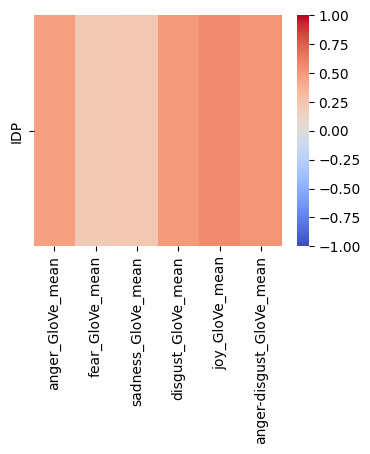

In [711]:
cm = pd.DataFrame()
if len(locs)>1 or "all" in locs:
    d = df.groupby("date_later").aggregate("mean")
    cm = corrMat(covar_cols, response_cols, d)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm.astype(float), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    cm["location"] = "all"
    plt.show()

#### Correlation Matrix Heat Map by Location

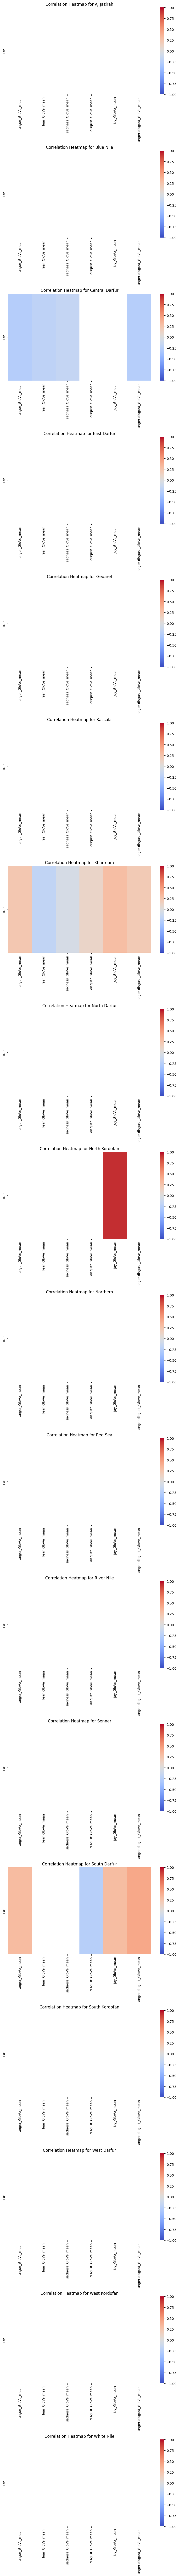

In [712]:
row_n = len(df["location"].unique())
fig, axes = plt.subplots(nrows=row_n, ncols=1, figsize=(8, row_n*6))
j=-1
for l, d in df.groupby("location"):
    j+=1
    ax = axes[j] if row_n > 1 else axes
    mat = corrMat(covar_cols, response_cols, d)
    sns.heatmap(mat.astype(float), annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)  
    ax.set_title(f'Correlation Heatmap for {l}') 

    mat["location"] = l
    if len(cm) == 0:
        cm = mat
    else:
        cm = pd.concat([cm, mat])
plt.tight_layout()
plt.show()

#### Correlation Matrix Numbers

In [713]:
cm[["location"]+[c for c in cm.columns if c != "location"]]

,location,anger_GloVe_mean,fear_GloVe_mean,sadness_GloVe_mean,disgust_GloVe_mean,joy_GloVe_mean,anger-disgust_GloVe_mean
IDP,all,0.461784,0.214342,0.229722,0.498879,0.565739,0.515749
IDP,Aj Jazirah,NaN,NaN,NaN,NaN,NaN,NaN
IDP,Blue Nile,NaN,NaN,NaN,NaN,NaN,NaN
IDP,Central Darfur,-0.271247,-0.217628,-0.173818,NaN,NaN,-0.262941
IDP,East Darfur,NaN,NaN,NaN,NaN,NaN,NaN
IDP,Gedaref,NaN,NaN,NaN,NaN,NaN,NaN
IDP,Kassala,NaN,NaN,NaN,NaN,NaN,NaN
IDP,Khartoum,0.228861,-0.189607,-0.060828,0.112396,0.294643,0.207652
IDP,North Darfur,NaN,NaN,NaN,NaN,NaN,NaN
IDP,North Kordofan,NaN,NaN,NaN,NaN,0.915195,NaN


#### Time Series Aggregated by Mean

In [714]:
if len(locs)>1:
    row_n = len(response_cols)
    d = df.groupby("date_later").aggregate("mean").reset_index()
    fig, axes = plt.subplots(nrows=row_n, ncols=1, figsize=(8, row_n*6))
    for i, r in enumerate(response_cols):
        response = scaler.fit_transform(d[[r]])
        ax = axes[i] if row_n > 1 else axes
        ax.plot(d["date_later"],response,label = r,linestyle='--')
        for cv in covar_cols:
            ax.plot(d["date_later"], d[cv], label=cv)
        ax.set_xlabel("Date")
        ax.set_ylabel(r)
        ax.set_xticks(d["date_later"])
        ax.set_xticklabels(d["date_later"].dt.strftime("%Y-%m-%d"), rotation=45)
        ax.set_title(f"average {r} and covariates over time")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


#### Time Series by Location

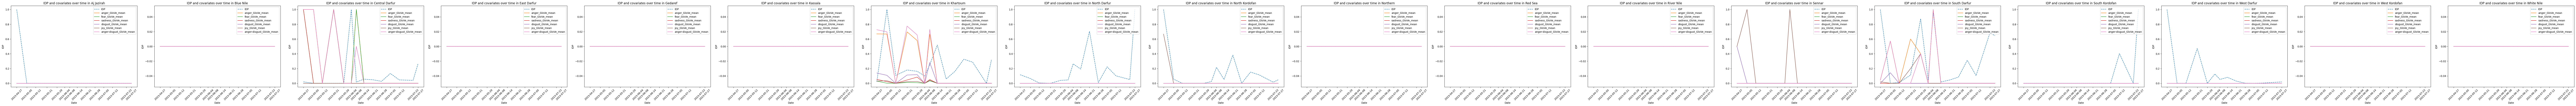

In [715]:
row_n = len(response_cols)
col_n = len(df["location"].unique())
fig, axes = plt.subplots(nrows=row_n, ncols=col_n, figsize=(col_n*8, row_n*6))
j=-1
for l, d in df.groupby("location"):
    j+=1
    d = d.sort_values("date_later")
    for i, r in enumerate(response_cols):
        response = scaler.fit_transform(d[[r]])

        if row_n > 1 and col_n > 1:
            ax = axes[i,j]
        elif row_n > 1:
            ax = axes[i]
        elif col_n > 1:
            ax = axes[j]
        else:
            ax = axes
            
        ax.plot(d["date_later"],response,label = r,linestyle = "--")
        for cv in covar_cols:
            ax.plot(d["date_later"], d[cv], label=cv)
        ax.set_xlabel("Date")
        ax.set_ylabel(r)
        ax.set_xticks(d["date_later"])
        ax.set_xticklabels(d["date_later"].dt.strftime("%Y-%m-%d"), rotation=45)
        ax.set_title(f"{r} and covariates over time in {l}")
        ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

#### Pairwise Plots Aggregated by Mean

In [716]:
if len(locs)>1:
    d = df.groupby("date_later").aggregate("mean").reset_index()
    row_n = len(covar_cols)
    col_n = len(response_cols)
    fig, axes = plt.subplots(nrows=row_n, ncols=col_n, figsize=(col_n*8, row_n*6))
    for i, r in enumerate(response_cols):
        for j, c in enumerate(covar_cols):
            d = d.sort_values(c)

            if row_n > 1 and col_n > 1:
                ax = axes[j,i]
            elif row_n > 1:
                ax = axes[j]
            elif col_n > 1:
                ax = axes[i]
            else:
                ax = axes
            
            ax.plot(d[c],d[r],label = r)
            ax.set_xlabel(c)
            ax.set_ylabel(r)
            ax.set_title(f"average {r} as a function of average {c}")
            ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

#### Pairwise Plots by Location

In [717]:
col_n = len(covar_cols)
row_n = len(df["location"].unique()) * len(response_cols)
fig, axes = plt.subplots(nrows=row_n, ncols=col_n, figsize=(col_n*8, row_n*6))
j=-1
for l, d in df.groupby("location"):
    for r in response_cols:
        j+=1
        for i, c in enumerate(covar_cols):
            if row_n > 1 and col_n > 1:
                ax = axes[j,i]
            elif row_n > 1:
                ax = axes[j]
            elif col_n > 1:
                ax = axes[i]
            else:
                ax = axes

            d = d.sort_values(c)
            ax.plot(d[c],d[r],label = r)
            ax.set_xlabel(c)
            ax.set_ylabel(r)
            ax.set_title(f"{r} as a function of {c} in {l}")
            ax.legend(loc="upper right")
plt.tight_layout()
plt.show()